In [24]:
%matplotlib inline

In [25]:
import jax
import numpy as np

import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

import optax

import flax
from flax import linen as nn
from flax.training import train_state

from tqdm import trange
from functools import partial
from matplotlib import pyplot as plt

from typing import NamedTuple, Any

# Diffusion models

## Intro
For every object in our data distribution $\mu^i \sim p_{\text{data}}(\mu)$ we define the noising process as
$$q_t^i(x) = \mathcal{N}(x|\alpha_t\mu^i,\sigma_t^2)\,.$$
The important part about defining this process is that we know the vector field satisfying the corresponding continuity equation
$$v_t^i(x) = (x-\alpha_t\mu^i)\frac{\partial}{\partial t}\log\sigma_t + \frac{\partial\alpha_t}{\partial t}\mu^i\,.$$
For the entire dataset we can write down the following marginal density
$$q_t(x) = \int \mathcal{N}(x|\alpha_t\mu,\sigma_t^2)p_{\text{data}}(\mu)d\mu\,,$$
and we can write down the loss for the vector field as
$$\text{Loss} = \frac{1}{N}\sum_{i=1}^N\int dt\;\int dx\;\Vert v_t(x;\theta) - v_t^i(x)\Vert^2\,,$$
where $\theta$ are the parameters of our model.

After training, we can simulate the process (generate data) via the following ODE
$$\frac{dx}{dt} = v_t(x)\,,\;\;\; v_t(x) = x\frac{\partial}{\partial t}\log\alpha_t - \beta_t\nabla_x\log q_t(x)\,,\;\;\beta_t = \sigma_t^2\frac{\partial}{\partial t}\log \frac{\sigma_t}{\alpha_t}\,,$$
or SDE
$$dx = (v_t(x) + \xi_t\nabla_x\log q_t(x))\cdot dt + \sqrt{2\xi_t}dW_t\,.$$

## Data Generation

$p_{\text{data}}(\mu)$ is just a mixture of four Gaussians. Then we define the noising process
$$q_t^i(x) = \mathcal{N}(x|\alpha_t\mu^i,\sigma_t^2)\,.$$
See code for $\alpha_t, \sigma_t$.
The plots represent samples from the following marginals for different times $t$
$$q_t(x) = \int \mathcal{N}(x|\alpha_t\mu,\sigma_t^2)p_{\text{data}}(\mu)d\mu\,.$$

In [26]:
# def sample_data(key, bs):
#     keys = random.split(key, 3)
#     x_1 = random.randint(keys[0], minval=0, maxval=2, shape=(bs, 2))
#     x_1 = 3 * (x_1.astype(jnp.float32) - 0.5)
#     x_1 += 4e-1 * random.normal(keys[1], shape=(bs, 2))
#     return x_1


def sample_data(key, bs, up=None):
    """
    Generate synthetic 2D data points.

    Args:
      key: JAX random key
      bs: Batch size
      up: If True, generate data in the upper region, otherwise in the lower region

    Returns:
      2D data points of shape (bs, 2)
    """
    keys = random.split(key, 3)
    if up == True:
        x_1 = random.randint(
            keys[0], minval=jnp.array([0, 1]), maxval=jnp.array([2, 2]), shape=(bs, 2)
        )
    elif up == False:
        x_1 = random.randint(
            keys[0], minval=jnp.array([0, 0]), maxval=jnp.array([2, 1]), shape=(bs, 2)
        )
    else:
        x_1 = random.randint(keys[0], minval=0, maxval=2, shape=(bs, 2))
    x_1 = 3 * (x_1.astype(jnp.float32) - 0.5)
    x_1 += 4e-1 * random.normal(keys[1], shape=(bs, 2))
    return x_1


t_0, t_1 = 0.0, 1.0
beta_0 = 0.1
beta_1 = 20.0


def log_alpha(t):
    return -0.5 * t * beta_0 - 0.25 * t**2 * (beta_1 - beta_0)


# log_sigma = lambda t: jnp.log(jnp.sqrt(-jnp.expm1(-t*beta_0-0.5*t**2*(beta_1-beta_0))))
def log_sigma(t):
    return jnp.log(t)


dlog_alphadt = jax.grad(lambda t: log_alpha(t).sum())
dlog_sigmadt = jax.grad(lambda t: log_sigma(t).sum())


# beta_t = s_t d/dt log(s_t/alpha_t)
# beta = lambda t: jnp.exp(log_sigma(t))*(dlog_sigmadt(t) - dlog_alphadt(t))
def beta(t):
    return 1 + 0.5 * t * beta_0 + 0.5 * t**2 * (beta_1 - beta_0)


def q_t(key, data, t):
    eps = random.normal(key, shape=data.shape)
    x_t = jnp.exp(log_alpha(t)) * data + jnp.exp(log_sigma(t)) * eps
    return eps, x_t

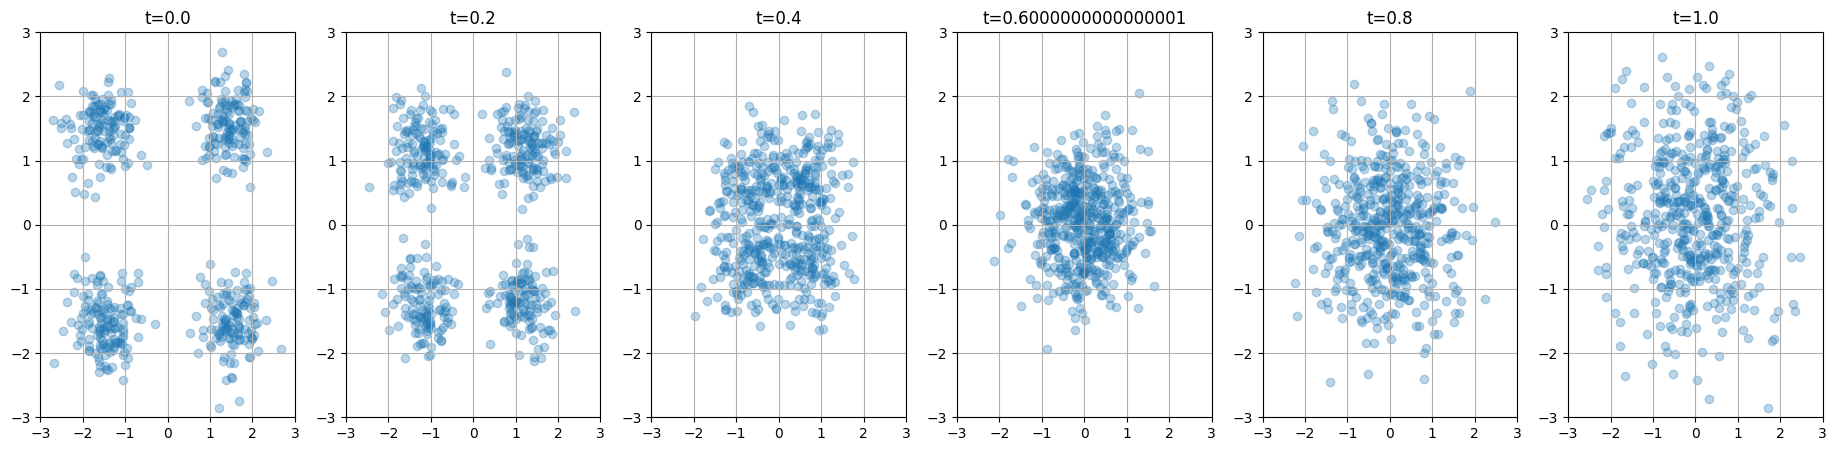

In [27]:
seed = 0
np.random.seed(seed)
key = random.PRNGKey(seed)
bs = 512
t_axis = np.linspace(0.0, 1.0, 6)
ndim = 2

plt.figure(figsize=(23, 5))
for i in range(len(t_axis)):
    plt.subplot(1, len(t_axis), i + 1)
    key, *ikey = random.split(key, 3)
    _, x_t = q_t(ikey[1], sample_data(ikey[0], bs), t_axis[i])
    plt.scatter(x_t[:, 0], x_t[:, 1], alpha=0.3)
    plt.title(f"t={t_axis[i]}")
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.grid()

## Define the Model

For the model of the vector field $v_t(x;\theta)$, we take an MLP.

In [28]:
class MLP(nn.Module):
    num_hid: int
    num_out: int

    @nn.compact
    def __call__(self, t, x):
        h = jnp.hstack([t, x])
        h = nn.Dense(features=self.num_hid)(h)
        h = nn.relu(h)
        h = nn.Dense(features=self.num_hid)(h)
        h = nn.swish(h)
        h = nn.Dense(features=self.num_hid)(h)
        h = nn.swish(h)
        h = nn.Dense(features=self.num_out)(h)
        return h

In [29]:
model = MLP(num_hid=512, num_out=x_t.shape[1])
print(model)

key, init_key = random.split(key)
optimizer = optax.adam(learning_rate=2e-4)
state = train_state.TrainState.create(
    apply_fn=model.apply,
    params=model.init(init_key, np.ones([bs, 1]), x_t),
    tx=optimizer,
)

MLP(
    # attributes
    num_hid = 512
    num_out = 2
)


## Loss Function

In general, the loss looks like this
$$\text{Loss} = \frac{1}{N}\sum_{i=1}^N\int dt\;\int dx\;\Vert v_t(x;\theta) - v_t^i(x)\Vert^2\,.$$
However, we rewrite it a bit in terms of the score and parametrize the following quantity
$$\text{MLP}(t,x;\theta) = \sigma_t\nabla_x\log q_t(x)\,.$$

In [30]:
def sm_loss(state, key, params, bs):
    keys = random.split(
        key,
    )

    def sdlogqdx(_t, _x):
        return state.apply_fn(params, _t, _x)

    data = sample_data(keys[0], bs)
    t = random.uniform(keys[1], [bs, 1])
    eps, x_t = q_t(keys[2], data, t)
    loss = ((eps + sdlogqdx(t, x_t)) ** 2).sum(1)
    print(loss.shape, "final.shape", flush=True)
    return loss.mean()


@partial(jax.jit, static_argnums=1)
def train_step(state, bs, key):
    grad_fn = jax.value_and_grad(sm_loss, argnums=2)
    loss, grads = grad_fn(state, key, state.params, bs)
    state = state.apply_gradients(grads=grads)
    return state, loss


key, loc_key = random.split(key)
state, loss = train_step(state, bs, loc_key)

(512,) final.shape


## Train Loop

In [31]:
num_iterations = 20_000

loss_plot = np.zeros(num_iterations)
key, loop_key = random.split(key)
for iter in trange(num_iterations):
    state, loss = train_step(state, bs, random.fold_in(loop_key, iter))
    loss_plot[iter] = loss

100%|██████████| 20000/20000 [00:15<00:00, 1260.09it/s]


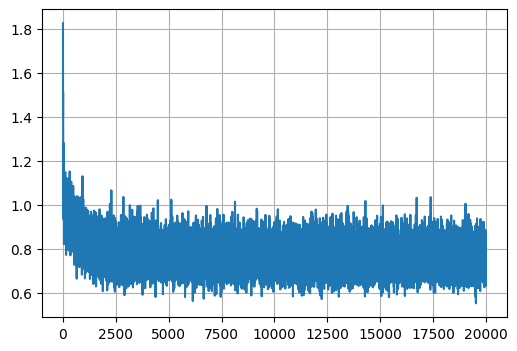

In [32]:
plt.figure(figsize=(6, 4))
plt.plot(loss_plot)
plt.grid()

## Evaluation of the Trained Model

For the evaluation we simply sample from $q_{t=1}$ and propogate samples back in time according to the ODE
$$\frac{dx}{dt} = v_t(x)\,,\;\;\; v_t(x) = x\frac{\partial}{\partial t}\log\alpha_t - \beta_t\nabla_x\log q_t(x)\,,\;\;\beta_t = \sigma_t^2\frac{\partial}{\partial t}\log \frac{\sigma_t}{\alpha_t}\,,$$
or SDE
$$dx = (v_t(x) + \xi_t\nabla_x\log q_t(x))\cdot dt + \sqrt{2\xi_t}dW_t\,.$$

In [33]:
# v_t(x) = dlog(alpha)/dt x - s^2_t d/dt log(s_t/alpha_t) dlog q_t(x)/dx
@jax.jit
def vector_field(t, x, xi=0.0):
    def sdlogqdx(_t, _x):
        return state.apply_fn(state.params, _t, _x)

    dxdt = (
        dlog_alphadt(t) * x
        - beta(t) * sdlogqdx(t, x)
        - xi * beta(t) / jnp.exp(log_sigma(t)) * sdlogqdx(t, x)
    )
    return dxdt

In [34]:
def generate_samples_ode(key, state):
    dt = 1e-2
    dt = 1e-2
    xi = 1.0
    t = 1.0
    n = int(t / dt)
    t = t * jnp.ones((bs, 1))
    key, ikey = random.split(key, num=2)
    x_gen = jnp.zeros((bs, n + 1, ndim))
    x_gen = x_gen.at[:, 0, :].set(random.normal(ikey, shape=(bs, ndim)))
    for i in trange(n):
        key, ikey = random.split(key, num=2)
        dx = -dt * vector_field(t, x_gen[:, i, :], xi) + jnp.sqrt(
            2 * xi * beta(t) * dt
        ) * random.normal(ikey, shape=(bs, 2))
        x_gen = x_gen.at[:, i + 1, :].set(x_gen[:, i, :] + dx)
        t += -dt
    return x_gen


key, ikey = random.split(key)
x_gen = generate_samples_ode(ikey, state)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 226.51it/s]


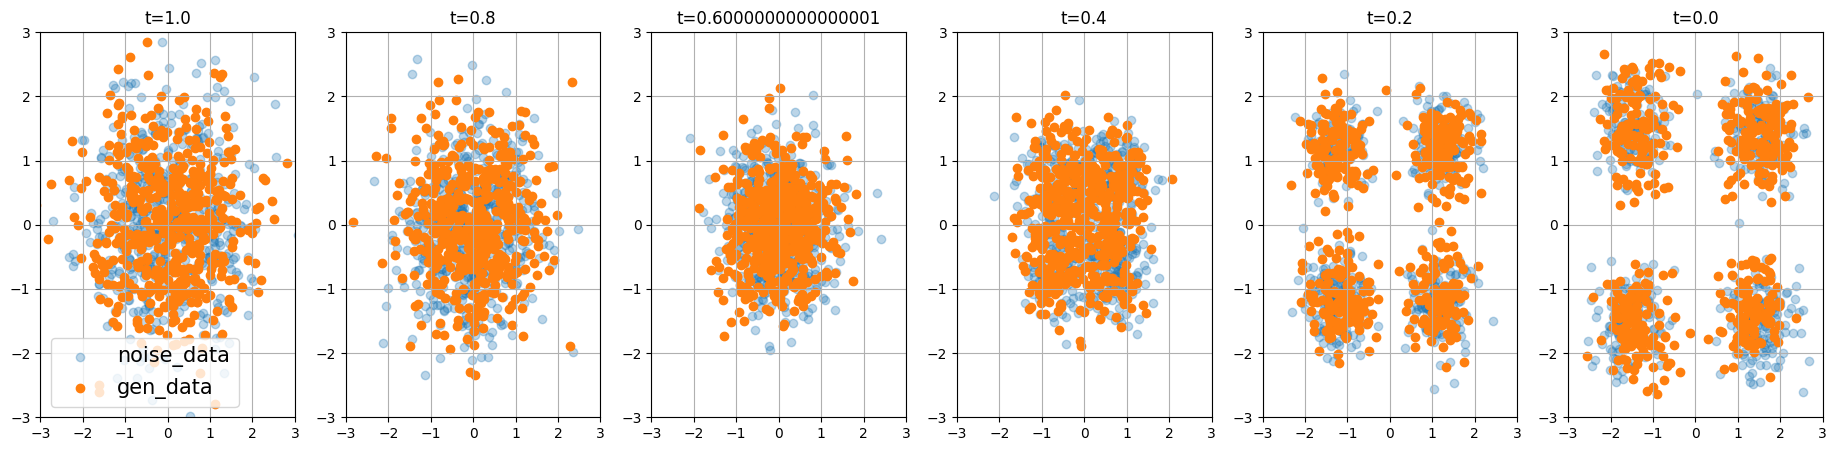

In [35]:
def plot_samples(x_gen, t_axis, key):
    plt.figure(figsize=(23, 5))
    n = x_gen.shape[1]
    for i in range(len(t_axis)):
        plt.subplot(1, len(t_axis), i + 1)
        key, *ikey = random.split(key, 3)
        t = t_axis[len(t_axis) - 1 - i]
        _, x_t = q_t(ikey[1], sample_data(ikey[0], bs), t)
        plt.scatter(x_t[:, 0], x_t[:, 1], label="noise_data", alpha=0.3)
        plt.scatter(
            x_gen[:, int(n * (t_axis[i])), 0],
            x_gen[:, int(n * (t_axis[i])), 1],
            label="gen_data",
        )
        plt.title(f"t={t:.2f}")
        plt.xlim(-3, 3)
        plt.ylim(-3, 3)
        plt.grid()
        if i == 0:
            plt.legend(fontsize=15)


plot_samples(x_gen, t_axis, key)

## SDE


In [36]:
# v_t(x) = dlog(alpha)/dt x - s^2_t d/dt log(s_t/alpha_t) dlog q_t(x)/dx
# dx = (v_t(x) - xi*beta_t*dlog q_t(x)/dx)dt + sqrt(2*beta_t*xi*dt)*eps
@jax.jit
def vector_field_SDE(state, t, x):
    sdlogqdx = lambda _t, _x: state.apply_fn(state.params, _t, _x)
    dxdt = dlog_alphadt(t) * x - 2 * beta(t) * sdlogqdx(t, x)
    return dxdt


def generate_samples_sde(key, state):
    dt = 1e-2
    t = 1.0
    n = int(t / dt)
    t = t * jnp.ones((bs, 1))
    key, ikey = random.split(key, num=2)
    x_gen = jnp.zeros((bs, n + 1, ndim))
    x_gen = x_gen.at[:, 0, :].set(random.normal(ikey, shape=(bs, ndim)))
    for i in trange(n):
        key, ikey = random.split(key, num=2)
        dx = -dt * vector_field_SDE(state, t, x_gen[:, i, :]) + jnp.sqrt(
            2 * jnp.exp(log_sigma(t)) * beta(t) * dt
        ) * random.normal(ikey, shape=(bs, 2))
        x_gen = x_gen.at[:, i + 1, :].set(x_gen[:, i, :] + dx)
        t += -dt
    return x_gen

  1%|          | 1/100 [00:00<00:26,  3.72it/s]

100%|██████████| 100/100 [00:00<00:00, 226.81it/s]


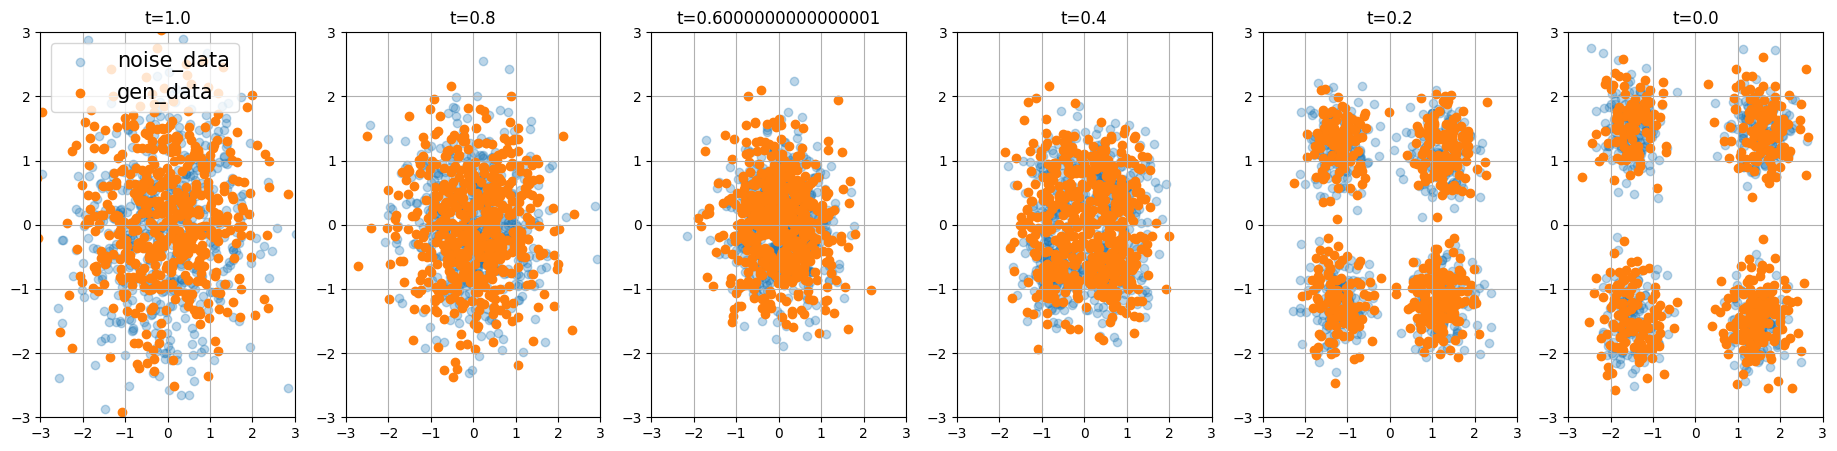

In [37]:
key, ikey = random.split(key)
x_gen = generate_samples_sde(ikey, state)
plot_samples(x_gen, t_axis, key)